<a href="https://colab.research.google.com/github/owosade/Explainable-AI---Final/blob/main/LIme_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive to '/content/gdrive'
drive.mount('/content/gdrive')

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
!pip install lime
import lime
from lime import lime_image
from fastai.vision.all import *
import cv2
#from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
from torchvision import models, transforms

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.6 MB/s et

In [2]:
path = Path('/content/gdrive/MyDrive/Dataset')
#dls = ImageDataLoaders.from_folder(path/'Kidney_stones', train='train', valid='valid')
train_fnames = get_image_files(path/"Train")
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]


dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=23),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )

dls = dblock.dataloaders(train_fnames)
# Step 2: Create a fastai Learner
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn = learn.load('/content/gdrive/MyDrive/Dataset/Final_project4')

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 49.3MB/s]


In [3]:
# Step 3: Prepare your data
# Assuming 'image_path' is the path to an image in your dataset

image_path =('/content/gdrive/MyDrive/Dataset/Test/Kidney_stone/1.3.46.670589.33.1.63706830475347975400001.4676991400730475635.png')

img = PILImage.create(image_path)


In [4]:

# Step 4: Create a LIME explainer
explainer = lime_image.LimeImageExplainer()
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

    # resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

model = models.inception_v3(pretrained=True)

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 55.6MB/s] 


  0%|          | 0/1000 [00:00<?, ?it/s]

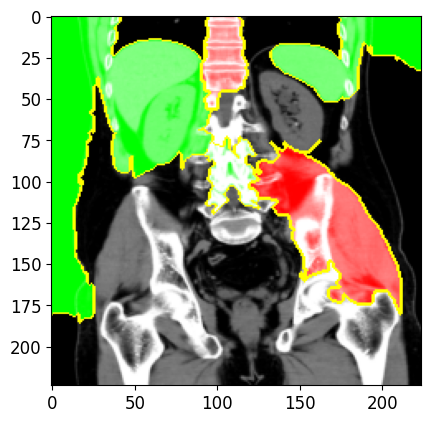

In [5]:
# Step 5: Generate explanations
# The predict function should take a PIL Image and return model predictions
def predict_function(img):
    #return learn.predict(PILImage.create(img))[2].numpy()
    pred = learn.predict(PILImage.create(img))
    return pred.probs.numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification function

# Explain the predictions for the given image
#explanation = explainer.explain_instance(img, predict_function, top_labels=1, hide_color=0, num_samples=1000)

from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
